## Smile Recognition Project on Olivetti Dataset

Here we import the necessary packages to classify the dataset into smiling and non-smiling categories. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image

#Visualization
import matplotlib.pyplot as plt


#System
import os

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print('done')

done


In [7]:
import warnings
warnings.filterwarnings('ignore')
print("Warnings ignored!!")

Warnings ignored!!


In [4]:
data=np.load("./olivetti_faces.npy")
targets=np.load("./olivetti_faces_target.npy")

Verifying the information in the dataset.

In [5]:
print("There are {} images in the dataset".format(len(data)))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))

There are 400 images in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[0.309917 0.367769 0.417355 0.442149]


In order to classify the data, the function below allows to see the images based on the ID. There are a number of IDs where the entire set is either smiling or not smiling. 5 IDs were viewed at a time for quicker classification. Those IDs whose entire set was either smiling or not are listed below:

**no_smile_id**: 0, 3, 13, 14, 17, 22, 28, 33, 35

**smile_id**: 4, 8 11,19, 21, 24, 26,38, 39

In [20]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols=10# each subject has 10 distinct face images
    rows=(len(subject_ids)*10)/cols #
    rows=int(rows)
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    #axarr=axarr.flatten()
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))
    

<Figure size 432x288 with 0 Axes>

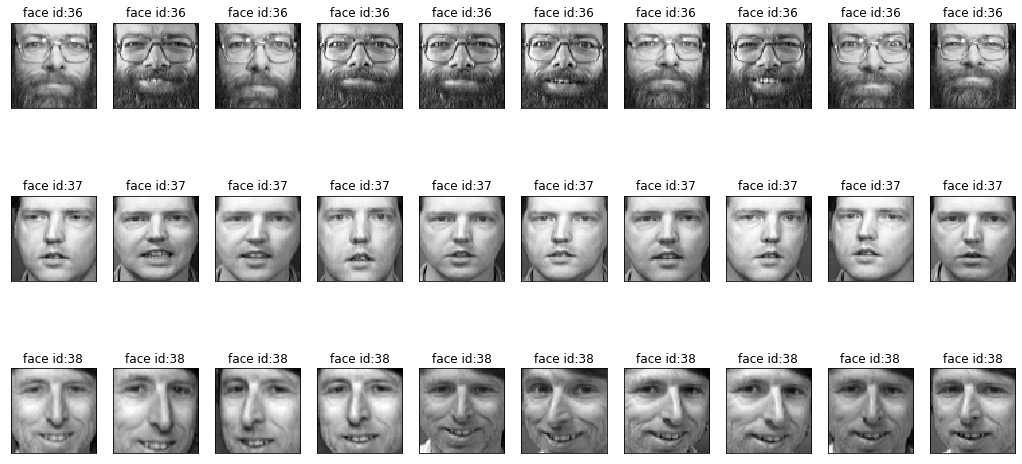

In [21]:
#You can playaround subject_ids to see other people faces
plt.clf()
show_10_faces_of_n_subject(images=data, subject_ids=list(range(36,39)))


After viewing the images, the function below was used to append the images into the respective list in order to classify the images into smiling and non-smiling.

In [22]:
def make_smile_data(list_data,images, subject_ids,entire_set = True,specific_index=[]):
    if entire_set:
        for i in subject_ids:
            for j in range(10):
                image_index=i*10 + j
                list_data.append(images[image_index])
    else:
        for i in specific_index:
            list_data.append(images[i])



In [23]:
smile_data = []
make_smile_data(smile_data,images=data, subject_ids=[4,7,8,11,19,21,24,26,38,39],entire_set = True)
make_smile_data(smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[16,20,21,22,26,27,51,61,62,63,64,66,69,90,91,92,93,94,95,96,97,98,100,101,102,103])
make_smile_data(smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[122,123,128,129,153,154,160,161,162,163,164,181,186,187,188,200,201,202,207])
make_smile_data(smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[234,252,253,255,258,273,274,276,278,291,293,295,297,300,303,305,306,307,308])
make_smile_data(smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[310,311,312,313,314,315,316,319,322,323,324,325,326,327,328,329,340,341,342,343,345,346,347,348,349])
make_smile_data(smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[361,363,364,365,367,368,369,371])

print(len(smile_data))
smile_data_image = [(i*255).astype('int') for i in np.array(smile_data)]

197


In [24]:
no_smile_data=[]
make_smile_data(no_smile_data,images=data, subject_ids=[0,3,13,14,17,22,28,33,35],entire_set = True)
make_smile_data(no_smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[10,11,12,13,14,15,17,18,19,23,24,25,28,29,50,52,53,54,55,56,57,58,59,60,65,67,68,99,104,105,106,107,108,109])
make_smile_data(no_smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[120,121,124,125,126,127,150,151,152,155,156,157,158,159,165,166,167,168,169,180,182,183,184,185,189,203,204,205,206,208,209])
make_smile_data(no_smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[230,231,232,233,235,236,237,238,239,250,251,254,256,257,259,270,271,272,275,277,279,290,292,294,296,298,299,301,302,304,309])
make_smile_data(no_smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[317,318,320,321,344])
make_smile_data(no_smile_data,images=data, subject_ids=[],entire_set = False,specific_index=[360,362,366,370,372,373,374,375,376,377,378,379])
print(len(no_smile_data))

no_smile_data_image = [(i*255).astype('int') for i in np.array(no_smile_data)]

203


During classification, there were a number of images that were quite ambiguous and quite difficult in classifying into the groups. Most of the smiling data were classfied on clear smiles that either showed teeth or the mouth is clearly in a 'U' shape. The classfication of the images could be handled better such as building a GUI but this method allows ease in terms of changing the classification later on. 

In [25]:
full_data = {} #Dict to label the values. 1 for smile and 0 for no smile. 
full_data[1] = smile_data
full_data[0] = no_smile_data


The function below appends all the data with their classification to training_data. The data would be append as a list where the zeroth index holds the array data of the image and the next index holds the label of a data in a one-hot format. The training data is also shuffled and saved where it can be easily used later on. 

In [26]:
if not os.path.exists('data'):
    os.makedirs('data')
    



In [27]:
a = os.path.join(path,'\\data\\train')
a

NameError: name 'path' is not defined

In [11]:
path = os.getcwd()
path = os.path.join(path,'data')
train_path = os.path.join(path,'train')
valid_path = os.path.join(path,'valid')
test_path = os.path.join(path,'test')
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(valid_path):
    os.makedirs(valid_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

In [29]:
train_smile_idx = round(0.2*len(smile_data_image))
train_nosmile_idx = round(0.2*len(no_smile_data_image))

np.random.shuffle(smile_data_image)
np.random.shuffle(no_smile_data_image)

train_data = {}
valid_data = {}
test_data = {}
train_data[1] = smile_data_image[:-train_smile_idx]
valid_data[1] = smile_data_image[-train_smile_idx:]
train_data[0] = no_smile_data_image[:-train_nosmile_idx]
valid_data[0] = no_smile_data_image[-train_nosmile_idx]
test_data[0] = train_data[0][-10:]
test_data[1] = train_data[1][-10:]
train_data[0] = train_data[0][:-10]
train_data[1] = train_data[1][:-10]
 


In [30]:
label = ['1','0']
train_done = True
valid_done = True
test_done = True

if not train_done:
    for i in label:
        file_path = os.path.join(train_path, i)
        if not os.path.exists(file_path):
            os.makedirs(file_path)

        for img_num,img in enumerate(train_data[int(i)]):
            file_name = f'{img_num+1}.jpg'
            cv2.imwrite(os.path.join(file_path,file_name), img)
            
if not valid_done:        
    for i in label:
        file_path = os.path.join(valid_path, i)
        if not os.path.exists(file_path):
            os.makedirs(file_path)

        for img_num,img in enumerate(valid_data[int(i)]):
            file_name = f'{img_num+1}.jpg'
            cv2.imwrite(os.path.join(file_path,file_name), img)
            
if not test_done:
    img_num = 0
    for i in label:
        file_path = test_path
        if not os.path.exists(file_path):
            os.makedirs(file_path)
        
        for img in test_data[int(i)]:
            file_name = f'{img_num+1}.jpg'
            cv2.imwrite(os.path.join(file_path,file_name), img)
            img_num+=1
    

In [13]:
path

'C:\\Users\\nzahi\\PycharmProjects\\DataAnalysis\\Smile Detector\\data'

In [3]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms = tfms, size = 64, test = 'test', bs=10)

NameError: name 'get_transforms' is not defined

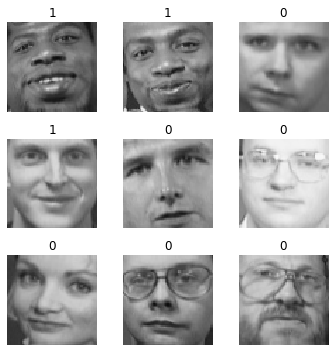

In [33]:
data.show_batch(rows=3, figsize = (5,5))

In [10]:
learn = cnn_learner(data, models.resnet50, metrics = accuracy)

In [107]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


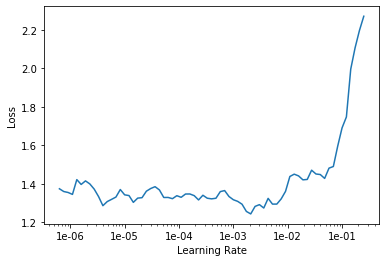

In [108]:
learn.recorder.plot()

In [109]:
learn.fit_one_cycle(10,max_lr =slice(6e-4,1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,1.305987,15.475738,0.116505,00:28
1,1.270613,0.770065,0.796117,00:29
2,1.184987,0.858471,0.844660,00:28
3,1.340966,0.319732,0.912621,00:28
4,1.206093,0.187076,0.951456,00:28
5,1.116126,0.091324,0.970874,00:27
6,0.947365,0.270942,0.912621,00:27
7,0.869837,0.173199,0.932039,00:29
8,0.784816,0.191121,0.951456,00:31
9,0.778759,0.164610,0.941748,00:30


In [110]:
learn.save('trained-2')

In [9]:
learn.load('trained-2')


In [10]:
ImageDataLoader

NameError: name 'ImageDataBunch' is not defined

In [74]:
preds = learn.get_preds(ds_type = DatasetType.Test)
preds

[tensor([[0.1248, 0.8752],
         [0.9466, 0.0534],
         [0.9692, 0.0308],
         [0.4209, 0.5791],
         [0.2466, 0.7534],
         [0.5358, 0.4642],
         [0.9765, 0.0235],
         [0.4251, 0.5749],
         [0.2953, 0.7047],
         [0.3082, 0.6918],
         [0.0073, 0.9927],
         [0.9944, 0.0056],
         [0.0159, 0.9841],
         [0.0594, 0.9406],
         [0.0072, 0.9928],
         [0.0029, 0.9971],
         [0.5935, 0.4065],
         [0.0309, 0.9691],
         [0.0110, 0.9890],
         [0.4405, 0.5595]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

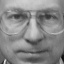

In [72]:
learn.data.test_ds[4][0]

In [112]:
res = []
for idx, file_name in enumerate(os.listdir(os.path.join(path,'test'))[1:]):
    label = file_name.split('.')[0]
    predicted_label = np.argmax(preds[0][idx])
    res_store= [label,predicted_label]
    res.append(res_store)
res

[['nosmile1', tensor(1)],
 ['nosmile10', tensor(0)],
 ['nosmile2', tensor(0)],
 ['nosmile3', tensor(1)],
 ['nosmile4', tensor(1)],
 ['nosmile5', tensor(0)],
 ['nosmile6', tensor(0)],
 ['nosmile7', tensor(1)],
 ['nosmile8', tensor(1)],
 ['nosmile9', tensor(1)],
 ['smile1', tensor(1)],
 ['smile10', tensor(0)],
 ['smile2', tensor(1)],
 ['smile3', tensor(1)],
 ['smile4', tensor(1)],
 ['smile5', tensor(1)],
 ['smile6', tensor(0)],
 ['smile7', tensor(1)],
 ['smile8', tensor(1)],
 ['smile9', tensor(1)]]

In [73]:
a = np.array([5,4,3,2,1])
np.argmax(a)

0

In [113]:
import cv2
from scipy.ndimage import zoom

faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")



def face_detect(path):
    test_img = cv2.imread(path)
    grayed_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    detected_face = faceCascade.detectMultiScale(grayed_img,1.1,5)
    return grayed_img, detected_face


def extract_face(grayed, detected_face_img):
    if len(detected_face_img)==0:
        return 'No face detected'
    for (x,y,w,h) in detected_face_img:
        extracted_face = grayed[y:y+h, x:x+w]
        extracted_face = zoom(extracted_face, (64. / extracted_face.shape[0], 64. / extracted_face.shape[1]))
        extracted_face = extracted_face.astype(float)
        extracted_face /= float(extracted_face.max())
    return extracted_face
                            
                            
def smiling(path):
    grayed_img,detected_face = face_detect(path)
    if len(detected_face)== 0:
        return 'Face not detected'
    

    else:
        face_extract = extract_face(grayed_img,detected_face)
        labels = ('not smiling','smiling')
        net_out = learn.predict(open_image(path))
        print(net_out)
        category = torch.argmax(net_out[-1])
        return labels[category]

(Category 0, tensor(0), tensor([1.0000e+00, 1.3217e-18]))
not smiling
(64, 64)


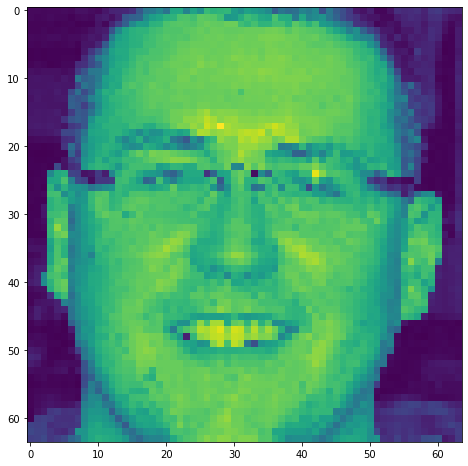

In [124]:


g,d_f = face_detect('smile_test_8.jpg')
face_extract = extract_face(g,d_f)
test_img = smiling('smile_test_8.jpg')
print(test_img)
plt.figure(figsize=(8,8))
plt.imshow(face_extract)
print(face_extract.shape)


In [ ]:
REBUILD_DATA = True


def make_training_data(all_data,filename ='training_data.npy' ):
    training_data = []
    smilecount = 0
    nosmilecount = 0
    for i in all_data:
        for j in all_data[i]:
            training_data.append([np.array(j),np.eye(2)[i]])
            if i ==1:
                smilecount +=1
            else:
                nosmilecount +=1
        
    np.random.shuffle(training_data)
    np.save(filename, training_data)
    print('Smile:', smilecount)
    print('No Smile:', nosmilecount)
       
if REBUILD_DATA:
    X = make_training_data(full_data)

In [ ]:
training_data = np.load('training_data.npy',allow_pickle = True)

The model is build using CNN that consist of 3 CNN layers and 2 fully connected layers. The self._to_linear portion is merely to initilize the input into the fully connected layer.

Rectified linear is used as the activation and a max pooling of size 2,2 is used.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,4)
        self.conv2 = nn.Conv2d(32,64,4)
        self.conv3 = nn.Conv2d(64,128,4)
        
        x = torch.rand(64,64).view(-1,1,64,64)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        #print(x[0].shape)
    def convs(self, x):
        x =F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x =F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x =F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net = Net()

Adam optimizer and Mean Squared Error is used for the optimizer and loss function respectively. The train and test data is split where the test data accounts for 20% of the entire dataset.

In [ ]:
import torch.optim as optim

optimizer =optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()
X = torch.Tensor([i[0] for i in training_data]).view(-1,64,64)
y = torch.Tensor([i[1] for i in training_data])
test_pct = 0.2
val_size = int(len(X)*test_pct)
train_X = X[:-val_size]
test_X = X[-val_size:]
train_y = y[:-val_size]
test_y = y[-val_size:]

#plt.figure(figsize=(8,8))
#plt.imshow(train_X[10],cmap='gray')
#print(train_y[10])

The model is then trained with a batch size of 5. Due to the small amount of data, a larger number of epochs was ran. 

In [ ]:
batch_size = 5
epochs = 20

for epoch in range(epochs):
    for i in tqdm(range(0,len(train_X),batch_size)):
        batch_X = train_X[i:i+batch_size].view(-1,1,64,64)
        batch_y = train_y[i:i+batch_size]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,64,64))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class ==real_class:
            correct+=1
        total+=1

print('Accuracy:', round(correct/total,3))

The model is saved and used to build the smile detector function. 

In [ ]:
path = 'smile-detector.pth'
torch.save(net,path)